# Дисциплина: КМСС

# Практика №9

## Задание

Напишите программы с использованием Python или C# для решения следующих задач.

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from numpy import ndarray
import pandas as pd
from pandas import DataFrame
from pandas import Series
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from collections import Counter
from itertools import chain

### Задача 1

Три игрока (с номерами 1, 2 и 3), имеющие изначально $X$, $Y$ и $Z$ жетонов соответственно, играют в следующую игру. В каждом раунде каждый игрок ставит на кон один жетон. Затем бросают кубик, на котором цифры 4, 5, 6 заменены на 1, 2 и 3. При выпадении числа $i$ игрок с номером $i$ забирает с кона все три жетона. Игра заканчивается, когда кто-нибудь из игроков проигрывает все жетоны. 

Введем функцию $f(X, Y, Z)$, как среднюю длительность игры (среднее количество раундов) при заданных начальных капиталах $X$, $Y$, $Z$. Например, $f(2, 2, 2) = 2$. Ваша задача состоит в том, чтобы определить эту функцию.

Для этого необходимо написать программу, моделирующую игру, накопить экспериментальные результаты, проанализировать их. А затем выдвигать гипотезы о виде функции $f$, проверять их для разных входных значений, и, отбросив неподходящие, найти решение.
&nbsp;

##### Примечание

_Решать данную задачу мы будем при помощи [метода Монте-Карло](https://www.youtube.com/watch?v=7ESK5SaP-bc)._

#### Класс игрока и функция игры

Для решения этой задачи сперва запрограммируем класс игрока и функцию игры, которые будут удовлетворять условию.

In [93]:
class NumberedPlayer:
    # Initializing number and tokens attributes
    def __init__(self, number: int, tokens: int):
        self.number = number
        self.tokens = tokens
    
    # Implementing player's ability to bet
    def bet(self):
        self.tokens -= 1
        return 1
    
    
def play_dice(players: list[NumberedPlayer, NumberedPlayer, NumberedPlayer]):
    # Initializing the dice
    dice = [1, 2, 3] * 2
    rounds = 0
    # Game kernel
    while True:
            
        stake = 0
        # Check if the game has ended
        for p in players:
            if p.tokens < 1: return rounds
            stake += p.bet()
                
        # Peek who takes the stake
        won = np.random.choice(dice)
        players[won - 1].tokens += stake
        rounds += 1

#### Создание образцов

Определим функцию для создания образцов. Так как нам не важно, кто именно победил, будем ассоциировать то или иное количество сыгранных раундов с __суммой__ монет игроков.

In [94]:
def generate_dice_game_samples(iterations_number: int, player_token_max: int):
    results_list = list()
    # Generating uniformly distributed samples
    for _ in range(iterations_number):
        # Declaring random token values
        players_tokens = [
            randint(1, player_token_max), randint(1, player_token_max), 
            randint(1, player_token_max)
        ]
        token_sum = sum(players_tokens)

        # Initializing players with random token values
        players_list = [
            NumberedPlayer(1, players_tokens[0]), NumberedPlayer(2, players_tokens[1]),
            NumberedPlayer(3, players_tokens[2])
        ]
        round_played = play_dice(players_list)

        results_list.append((token_sum, round_played))
    return results_list

#### Конвейер моделей

Вместо того чтобы множество раз повторять цикл обработки данных и обучения модели, сконструируем конвейер моделей. Его мы уже будем применять к каждой выборке образцов. Так как мы знаем, что все входные параметры случайны, воспользуемся классом `StandardScaler` для нормализации данных. Модели `LinearReggression` для наших нужд будет вполне достаточно.

In [95]:
steps = [("scaler", StandardScaler()), ("regressor", LinearRegression())]
pipeline = Pipeline(steps)

#### Функции заворачивания

Реализуем функции, заворачивающие исходы игр и результаты модели в более читаемый формат.

In [96]:
def wrap_samples(results_list: list):
    token_sums, rounds_played = list(), list()
    counter_map = dict(Counter(results_list))

    samples = counter_map.keys()
    samples = list(chain(samples))

    for s in samples:
        token_sums.append(s[0]), rounds_played.append(s[1])

    samples_entries = counter_map.values()
    samples_entries = list(chain(samples_entries))
    
    # Wrapping samples to DataFrame
    samples_frame = pd.DataFrame(
        {
            "token_sum": np.array(token_sums), 
            "rounds_played": np.array(rounds_played), 
            "entries": np.array(samples_entries)
        }
    )
    
    return samples_frame

def wrap_trained(X: Series | DataFrame, y: Series | DataFrame, p: ndarray):
    p = pd.Series(p, name="predicted")
    trained_frame = pd.concat([X, y], axis="columns")
    # Resolving index conflicts
    trained_frame.index = range(len(trained_frame))
    
    trained_frame = pd.concat([trained_frame, p], axis="columns")
    trained_frame.columns = ["X_test", "y_test", "predicted"]
    
    return trained_frame

#### Визуализация результатов

Также очень полезно иметь абстракцию для визуализации результатов. Ниже представлена её реализация.

In [97]:
def get_plot(truth: DataFrame, trained: DataFrame):
    sums, rounds_numbers, entries = (
        truth["token_sum"], truth["rounds_played"], truth["entries"]
    )
    overall_truth = sum(entries)
    # Setting fancy borders
    max_sums = max(sums)
    max_rounds = max(rounds_numbers)
    max_x = max_sums + 10 - max_sums % 10
    max_y = max_rounds + 10 - max_rounds % 10
    
    X_true, y_true, y_predicted = (
        trained["X_test"], trained["y_test"], trained["predicted"]
    )
    overall_predicted = len(X_true)
    
    figure, axes = plt.subplots(2)

    # Scattering actual results
    axes[0].scatter(sums, rounds_numbers, s=np.log(entries), c=sums, alpha=0.25)
    # Comparing actual data to model predictions
    axes[1].scatter(X_true, y_true, s=1, alpha=0.75)
    axes[1].plot(X_true, predicted, c="red")
    
    for i, _ in enumerate(axes):
        axes[i].set_xlim(0, max_x)
        axes[i].set_ylim(0, max_y)
        axes[i].set_xlabel("Token sums")
        axes[i].set_ylabel("Rounds played")
        axes[i].grid(True)
    axes[0].set_xlabel("")
        
    figure.suptitle(
        f"Game samples ({overall_truth}) and Model predictions ({overall_predicted})"
    )
    plt.show()

#### Численные эксперименты и метод Монте-Карло в действии

Теперь, имея все необходимые инструменты, поставим несколько численных экспериментов. Будем менять количество образцов в целом, а максимальное количество монет у каждого игрока пускай будет равно 12. Оставим последнее без изменений, чтоб ускорить сходимость процесса.
&nbsp;

Вы, конечно, можете поэкспериментировать с максимальным количеством монет просто изменив аргумент `player_token_max` функции `generate_dice_game_samples()`

__Эксперимент 1__

Установим количество образцов равным 100.

In [98]:
results = generate_dice_game_samples(100, player_token_max=12)
samples_wrapped = wrap_samples(results)

samples_wrapped

,token_sum,rounds_played,entries
0,11,3,2
1,17,8,1
2,14,7,1
3,12,2,1
4,29,151,1
...,...,...,...
77,19,2,1
78,16,4,1
79,27,13,1
80,17,1,1


In [99]:
samples_wrapped_dropped = samples_wrapped.drop(["entries"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    samples_wrapped_dropped.drop("rounds_played", axis=1), samples_wrapped_dropped["rounds_played"],
    test_size=0.25, random_state=25
)

pipeline.fit(X_train, y_train)
predicted = np.round(pipeline.predict(X_test))

In [100]:
trained_wrapped = wrap_trained(X_test, y_test, predicted)

trained_wrapped

,X_test,y_test,predicted
0,24,31,25.0
1,26,12,29.0
2,14,2,4.0
3,11,3,-2.0
4,22,10,21.0
5,20,23,17.0
6,21,24,19.0
7,15,3,6.0
8,29,55,36.0
9,16,10,8.0


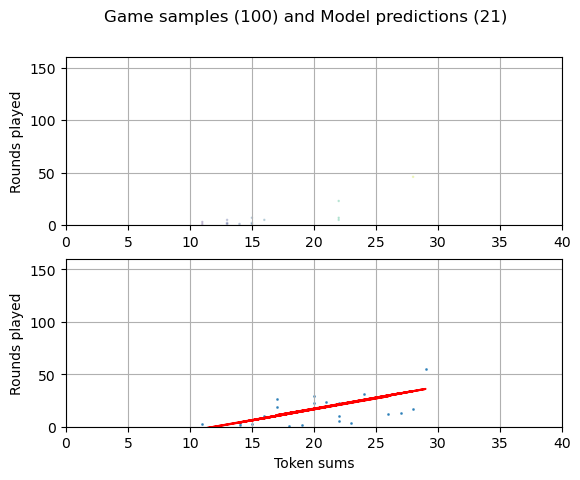

In [101]:
get_plot(samples_wrapped, trained_wrapped)

In [102]:
experiment_1_score = pipeline.score(X_test, y_test)

experiment_1_score

0.1898644130606818

__Эксперимент 2__

На этот раз пусть количество образцов равняется 1000.

In [103]:
results = generate_dice_game_samples(1000, player_token_max=12)
samples_wrapped = wrap_samples(results)

samples_wrapped

,token_sum,rounds_played,entries
0,13,3,4
1,14,9,4
2,12,6,4
3,17,15,1
4,14,2,10
...,...,...,...
406,28,20,1
407,24,3,1
408,21,32,1
409,29,126,1


In [104]:
samples_wrapped_dropped = samples_wrapped.drop(["entries"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    samples_wrapped_dropped.drop("rounds_played", axis=1), samples_wrapped_dropped["rounds_played"],
    test_size=0.25, random_state=25
)

In [105]:
pipeline.fit(X_train, y_train)
predicted = np.round(pipeline.predict(X_test))
trained_wrapped = wrap_trained(X_test, y_test, predicted)

trained_wrapped

,X_test,y_test,predicted
0,11,5,6.0
1,19,6,16.0
2,16,3,12.0
3,13,2,8.0
4,23,7,21.0
...,...,...,...
98,25,34,24.0
99,24,84,23.0
100,22,17,20.0
101,23,26,21.0


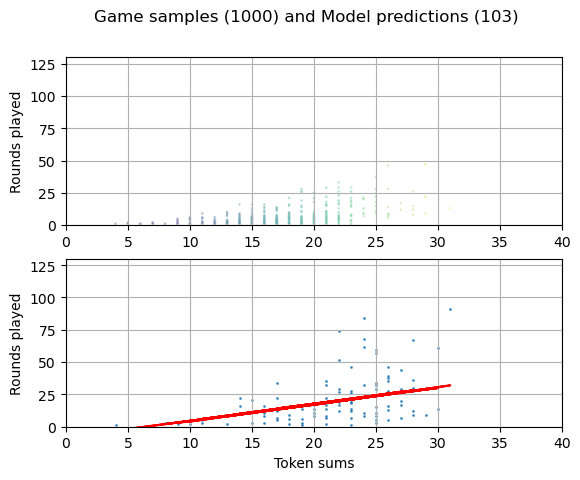

In [106]:
get_plot(samples_wrapped, trained_wrapped)

In [107]:
experiment_2_score = pipeline.score(X_test, y_test)

experiment_2_score

0.198803403523233

__Эксперимент 3__

Теперь пускай максимальная сумма монет будет равна 10000.

In [108]:
results = generate_dice_game_samples(10_000, player_token_max=12)
samples_wrapped = wrap_samples(results)

samples_wrapped

,token_sum,rounds_played,entries
0,10,1,109
1,16,1,126
2,23,48,2
3,20,14,22
4,12,2,76
...,...,...,...
982,23,55,1
983,26,86,1
984,18,26,1
985,19,45,1


In [109]:
samples_wrapped_dropped = samples_wrapped.drop(["entries"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    samples_wrapped_dropped.drop("rounds_played", axis=1), samples_wrapped_dropped["rounds_played"],
    test_size=0.25, random_state=25
)

In [110]:
pipeline.fit(X_train, y_train)

predicted = np.round(pipeline.predict(X_test))
trained_wrapped = wrap_trained(X_test, y_test, predicted)

trained_wrapped

,X_test,y_test,predicted
0,26,74,38.0
1,13,3,14.0
2,10,2,9.0
3,11,7,10.0
4,28,30,42.0
...,...,...,...
242,31,101,47.0
243,29,21,44.0
244,23,77,32.0
245,11,10,10.0


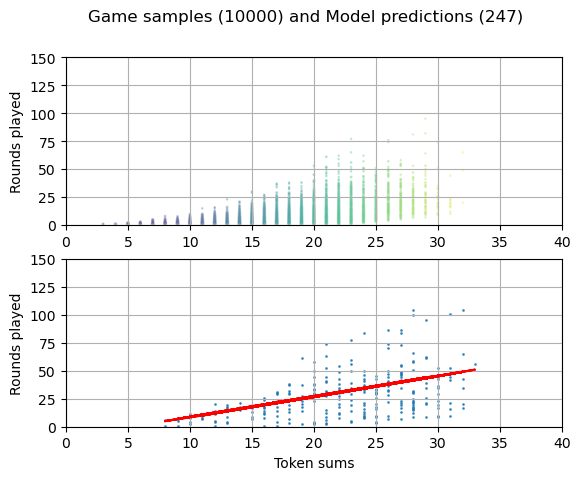

In [111]:
get_plot(samples_wrapped, trained_wrapped)

In [112]:
experiment_3_score = pipeline.score(X_test, y_test)

experiment_3_score

0.1874394725520092

__Эксперимент 4__

Установим наконец количество образцов равным 100000.

In [113]:
results = generate_dice_game_samples(100_000, player_token_max=12)
samples_wrapped = wrap_samples(results)

samples_wrapped

,token_sum,rounds_played,entries
0,21,3,319
1,26,17,84
2,16,1,1174
3,17,2,788
4,24,20,117
...,...,...,...
1664,30,158,1
1665,29,107,1
1666,19,77,1
1667,30,176,1


In [114]:
samples_wrapped_dropped = samples_wrapped.drop(["entries"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    samples_wrapped_dropped.drop("rounds_played", axis=1), samples_wrapped_dropped["rounds_played"],
    test_size=0.25, random_state=25
)

In [115]:
pipeline.fit(X_train, y_train)

predicted = np.round(pipeline.predict(X_test))
trained_wrapped = wrap_trained(X_test, y_test, predicted)

trained_wrapped

,X_test,y_test,predicted
0,32,20,69.0
1,30,105,64.0
2,29,38,61.0
3,13,8,20.0
4,29,59,61.0
...,...,...,...
413,25,48,51.0
414,32,46,69.0
415,21,27,41.0
416,28,74,59.0


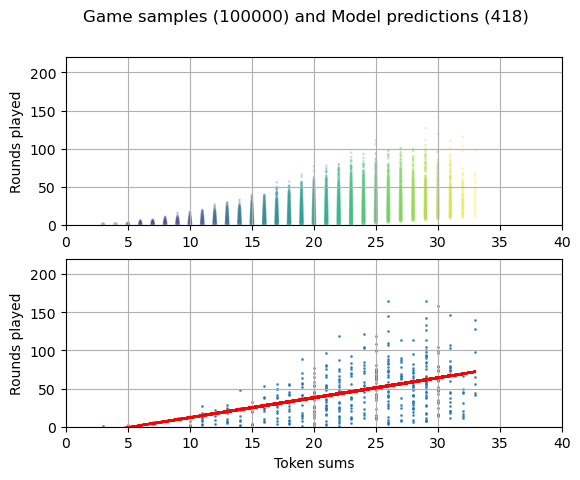

In [116]:
get_plot(samples_wrapped, trained_wrapped)

In [117]:
experiment_4_score = pipeline.score(X_test, y_test)

experiment_4_score

0.21412957016700562

#### Вывод

Итак, нетрудно заметить, чем больше количество монет у каждого из игроков на старте игры, тем менее предсказуемыми становятся исходы. Казалось бы, следствием этой данности будет являться линейно убывающая точность модели линейной регрессии. Однако это не так. Имея всё большее количество результатов игры с различными входными параметрами, вероятность получить правильный ответ от модели увеличивается. Довольно интересная интуиция для закона больших чисел, не так ли?

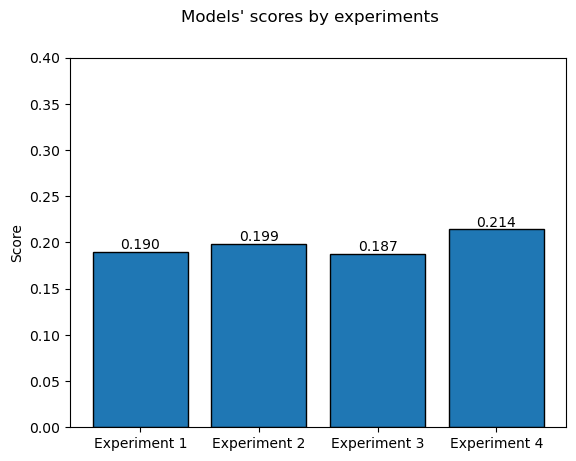

In [136]:
labels = ["Experiment 1", "Experiment 2", "Experiment 3", "Experiment 4"]
scores = [experiment_1_score, experiment_2_score, experiment_3_score, experiment_4_score]
max_score = max(scores)
score_limit = (max_score - max_score % 0.10) * 2

graphic, axis = plt.subplots()
bar_container = axis.bar(labels, scores, edgecolor="black")

axis.bar_label(bar_container, fmt='{:.3f}')
axis.set_ylim(0, score_limit)
axis.set_ylabel("Score")
graphic.suptitle("Models' scores by experiments")
plt.show()

### Задача 2

Игрок $A$ выбирает комбинацию из цифр 0 и 1 длиной 3 знака (например, 001). Игрок $B$ выбирает свою комбинацию (отличную от игрока $A$). Подбрасывается монета и записываются результаты бросания (например, 101101, где 0 обозначает «орел», а 1 — «решка»). Игра прекращается в тот момент, когда в последовательности цифр на конце возникает комбинация, выбранная $A$ или $B$ (побеждает $A$ или $B$ соответственно). Игра повторяется.

1. Оценить шансы на выигрыш каждого из игроков $\textrm{R}(A, B)$ (т.е. отношение числа выигрышей игрока $B$ к числу выигрышей игрока $A$);
2. Для выбранной игроком $A$ комбинации определить такую комбинацию для игрока $B$, которая ему дает больше шансов на выигрыш.

Ниже представлена таблица значений $\textrm{R}(A, B)$ для всевозможных выбранных игроками $A$ и $B$ исходных комбинаций при «неограниченном продолжении» игры (выделены наиболее выигрышные ситуации для игрока $B$).
&nbsp;

| $\frac{A}{B}$ | __000__ | __001__ | __010__ | __011__ | __100__ | __101__ | __110__ | __111__ |
|:-------------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|
|    __000__    |    -    |    1    |   2/3   |   2/3   |   1/7   |   5/7   |   3/7   |    1    |
|    __001__    |    1    |    -    |    2    |    2    |   1/3   |   5/3   |    1    |   7/3   |
|    __010__    |   3/2   |   1/2   |    -    |    1    |    1    |    1    |   3/5   |   7/5   |
|    __011__    |   3/2   |   1/2   |    1    |    -    |    1    |    1    |    3    |    7    |
|    __100__    |    7    |    3    |    1    |    1    |    -    |    1    |   1/2   |   3/2   |
|    __101__    |   7/5   |   3/5   |    1    |    1    |    1    |    -    |   1/2   |   3/2   |
|    __110__    |   7/3   |    1    |   5/3   |   1/3   |    2    |    2    |    -    |    1    |
|    __111__    |    1    |   3/7   |   5/7   |   1/7   |   2/3   |   2/3   |    1    |    -    |
&nbsp;

Пари является беспроигрышным (!) для игрока $B$. Парадокс заключается в том, что какую бы комбинацию цифр не выбрал игрок $A$, его соперник $B$ может выбрать другую комбинацию, которая ему дает больше шансов на выигрыш.

#### Класс игрока и функция игры

Реализуем игрока как класс и игру как функцию. У игрока в качестве идентификатора будет буква. А игра будет останавливаться, когда последние три цифры в последовательности будут равны комбинации, что хранится в соответствующем атрибуте игрока.

In [119]:
class NamedPlayer:
    # Initializing letter and combination attributes
    def __init__(self, letter: str, combination: str):
        self.letter = letter
        self.combination = combination
        
    
def play_coin(players: list[NamedPlayer, NamedPlayer]):
    sequence = ""
    # Game kernel
    while True:
        for p in players:
            # Check if the combination associated player matches last 3 digits
            if sequence[-3:] == p.combination: return p
            
        # Flipping the coin
        coin_side = str(randint(0, 2))
        sequence += coin_side

#### Генерация образцов

Введём функцию, которая будет искусственно собирать статистику и возвращать список отношений.

In [198]:
def generate_coin_game_samples(
        games_number: int, iterations_number: int, combination_a: str, combination_b: str
):
    ratios_list = list()
    # Generating a certain number of samples
    for _ in range(games_number):
        
        winners_list = list()
        for _ in range(iterations_number):
            # Initializing players with corresponding combinations passed
            players_list = [NamedPlayer("A", combination_a), NamedPlayer("B", combination_b)]
            winner = play_coin(players_list)
            
            winners_list.append(winner.letter)
        
        # Counting up the scores
        counts = dict(Counter(winners_list))
        ratio = counts["B"] / counts["A"]
        ratios_list.append(ratio)
    
    return ratios_list

#### Визуализация результатов

Также полезно определить функцию для иллюстрирования полученных статистик. На графике будем сравнивать данное в таблице отношение с изготовленными данными.

In [204]:
def draw_stats(ratios: list, expected_ratio: float):
    x_ticks = [i + 1 for i in range(len(ratios))]
    max_ratio = max(ratios)
    max_x = max(x_ticks) + 1
    max_y = max_ratio + 10 - max_ratio % 10

    figure, axes = plt.subplots()
    
    # Comparing actual game results to predictionary ratios
    axes.axhline(y=expected_ratio, color="red")
    axes.scatter(x_ticks, ratios)
    
    axes.set_xlim(0, max_x)
    axes.set_ylim(0, max_y)
    axes.set_xlabel("Game number")
    axes.set_ylabel("Win rate ratio")
    axes.set_xticks(x_ticks)
    axes.grid(True)
    
    figure.suptitle("Actual vs expected win ratios (B / A) ")
    plt.show()

#### Численные эксперименты

Проведём несколько численных экспериментов с различными входными данными. Так мы продемонстрируем достоверность таблицы, данной в условии задачи

__Эксперимент 1__

Для начала разыграем 10 партий. Для каждой партии количество итераций будет равно 100. Комбинациями для игроков $A$ и $B$ выберем 010 и 110 соответственно. В итоге должно выполняться отношение $\frac{5}{3}$ побед $B$ к $A$. Далее станем увеличивать количество партий и итераций, проверяя различные отношения.

In [207]:
results = generate_coin_game_samples(
    10, iterations_number=100, combination_a="010", combination_b="110"
)
results_series = pd.Series(results, name="B_to_A_win_rate")

results_series

0    1.325581
1    2.703704
2    1.564103
3    1.564103
4    1.777778
5    1.325581
6    1.439024
7    1.631579
8    2.030303
9    1.564103
Name: B_to_A_win_rate, dtype: float64

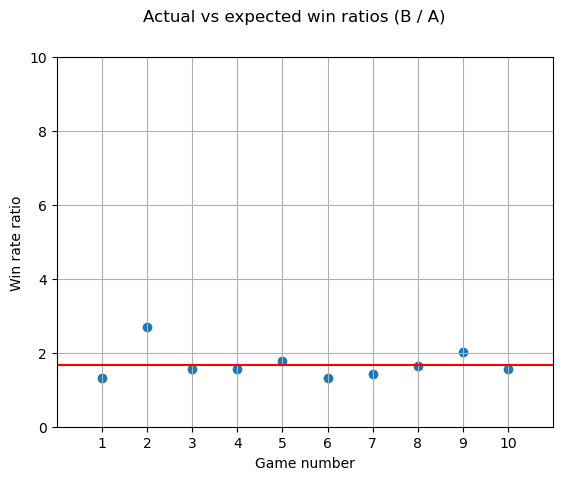

In [208]:
draw_stats(results, expected_ratio=5 / 3)

__Эксперимент 2__

Рассмотрим теперь комбинации 000 и 001 с предполагаемым отношением побед равным $\frac{7}{5}$.

In [209]:
results = generate_coin_game_samples(
    15, iterations_number=1000, combination_a="000", combination_b="101"
)
results_series = pd.Series(results, name="B_to_A_win_rate")

results_series

0     1.272727
1     1.409639
2     1.293578
3     1.304147
4     1.398082
5     1.386635
6     1.531646
7     1.320186
8     1.380952
9     1.631579
10    1.325581
11    1.309469
12    1.341920
13    1.403846
14    1.421308
Name: B_to_A_win_rate, dtype: float64

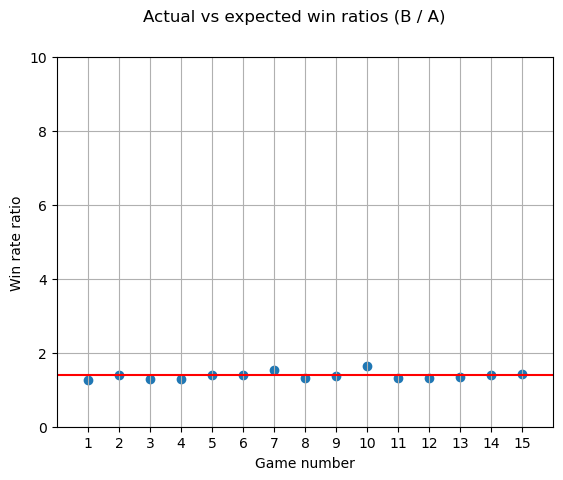

In [210]:
draw_stats(results, expected_ratio=7 / 5)

__Эксперимент 3__

На этот раз убедимся в высокой вероятности возникновения отношения $\frac{3}{1}$ для комбинаций 110 и 011 игроков $A$ и $B$ соответственно. 

In [211]:
results = generate_coin_game_samples(
    20, iterations_number=10_000, combination_a="110", combination_b="011"
)
results_series = pd.Series(results, name="B_to_A_win_rate")

results_series

0     2.995206
1     2.943218
2     3.084967
3     2.880481
4     3.032258
5     3.154549
6     2.935458
7     2.944773
8     3.033885
9     3.083299
10    2.993610
11    2.898635
12    2.998401
13    3.053506
14    3.076641
15    2.954132
16    2.883495
17    2.980892
18    3.060089
19    3.100041
Name: B_to_A_win_rate, dtype: float64

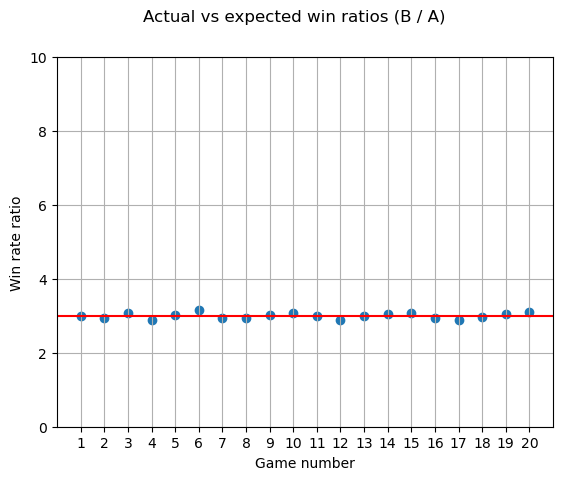

In [212]:
draw_stats(results, expected_ratio=3 / 1)

__Эксперимент 4__

Наконец, увеличив количество итераций до 100000, посмотрим на выполнения отношения $\frac{7}{1}$. Комбинации при этом будут 111 для $A$ и 011 для $B$.

In [213]:
results = generate_coin_game_samples(
    25, iterations_number=100_000, combination_a="111", combination_b="011"
)
results_series = pd.Series(results, name="B_to_A_win_rate")

results_series

0     6.838219
1     7.018603
2     7.025682
3     7.006405
4     7.109642
5     7.041171
6     6.961783
7     7.018603
8     6.913271
9     6.963686
10    7.067118
11    7.090615
12    6.942181
13    7.021176
14    6.991050
15    7.011537
16    6.946599
17    7.059317
18    6.855460
19    6.999360
20    6.912018
21    6.991689
22    6.970668
23    6.875256
24    6.925186
Name: B_to_A_win_rate, dtype: float64

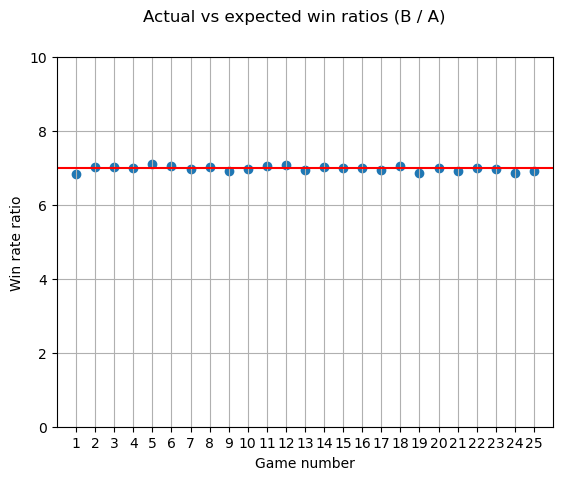

In [214]:
draw_stats(results, expected_ratio=7 / 1)

#### Вывод

По результатам выполнения экспериментов 1‒4 можно судить о довольно скорой сходимости действительных показателей к теоретически полагаемым отношениям. Так, если переходить к пределу, когда количество итераций будет стремиться к $\infty$, мы непременно получим табличное отношение.